In [4]:
import numpy as np
import edf
from time import time
import sys
import matplotlib.pyplot as plt

data = np.load('./c10_data/train.npz')
t_imgs = np.float32(data['imgs'])/255.

# Reshape the train image data to (idx, h, w, channel)
t_imgs = t_imgs.reshape(50000, 32, 32, 3)
t_labels = np.float32(data['labels'])

data = np.load('./c10_data/test.npz')
v_imgs = np.float32(data['imgs'])/255.

# Reshape the valid image data to (idx, h, w, channel)
v_imgs = v_imgs.reshape(10000, 32, 32, 3)
v_labels = np.float32(data['labels'])

In [5]:
########################################### Convolution layer#############################################
############################### Please implement the forward and backward method in this class ############## 
class Conv:
    def __init__(self, f, k, stride=1, pad=0):
        edf.components.append(self)
        self.f = f
        self.k = k
        pad = np.array(pad)
        if pad.shape == ():
            self.xpad = self.ypad = pad
        else:
            self.ypad = pad[0]
            self.xpad = pad[1]
            
        self.stride = stride
        self.grad = None if f.grad is None and k.grad is None else edf.DT(0) 

    ####################### Please implement this function####################### 
    def forward(self):
        xshape = self.k.value.shape
        fshape = self.f.value.shape
        
        # padding
        padded = np.ndarray([xshape[0],
                             xshape[1] + 2 * self.xpad,
                             xshape[2] + 2 * self.ypad,
                             xshape[3]],
                            self.k.value.dtype)
        padded.fill(0)
        padded[:, self.xpad: xshape[1] + self.xpad , self.ypad : xshape[2] + self.ypad , :] = self.k.value
        pshape = padded.shape
        # Calculate shape
        owsize = int(np.ceil((pshape[1] - fshape[0] + 1) / self.stride))
        ohsize = int(np.ceil((pshape[2] - fshape[1] + 1) / self.stride))
        self.value = np.ndarray([xshape[0], owsize, ohsize, fshape[3]], np.dtype(np.float64))
        yshape = self.value.shape
        
        for wi in range(yshape[1]):
            for hi in range(yshape[2]):
                slide = padded[:, self.stride * wi : self.stride * wi + fshape[0],
                               self.stride * hi : self.stride * hi + fshape[1], :]
                self.value[:, wi, hi, :] = np.einsum('buvc,uvcp->bp', slide, self.f.value)
                
    ####################### Please implement this function#######################         
    def backward(self):
        if self.k.grad is None or self.f.grad is None:
            return
        
        kshape = self.k.value.shape
        fshape = self.f.value.shape
        fgrad = np.ndarray(fshape, np.dtype(np.float64))
        fgrad.fill(0)
        pad_kgrad = np.ndarray([kshape[0], kshape[1] + 2 * self.xpad,
                                kshape[2] + 2 * self.ypad, kshape[3]],
                               np.dtype(np.float64))
        pad_kgrad.fill(0)
        pad_kval = np.ndarray(pad_kgrad.shape, self.k.value.dtype)
        pad_kval.fill(0)
        pad_kval[:, self.xpad: kshape[1] + self.xpad , self.ypad : kshape[2] + self.ypad , :] = self.k.value
        
        
        yshape = self.value.shape
        
        for wi in range(yshape[1]):
            for hi in range(yshape[2]):
                woffset = self.stride * wi
                hoffset = self.stride * hi
                grad_slide = self.grad[:, wi, hi, :]
                pad_kgrad[:, woffset: woffset + fshape[0], 
                          hoffset:hoffset + fshape[1], :] += np.einsum('ij,kmnj->ikmn', grad_slide, self.f.value)
                
                xslide = pad_kval[:, woffset: woffset + fshape[0], hoffset:hoffset + fshape[1], :]
            
                fgrad += np.einsum('imnk,ij->mnkj', xslide, grad_slide)
                                    
        self.f.grad += fgrad
        self.k.grad += pad_kgrad[:, self.xpad:self.xpad + kshape[1], self.ypad:self.ypad + kshape[2], :]

########################################### MaxPool layer#############################################
############################### Please implement the forward abd backward method in this class ##############             
class MaxPool:
    def __init__(self, x, ksz=2, stride=None):
        edf.components.append(self)
        self.x = x
        self.ksz = ksz
        if stride is None:
            self.stride = ksz
        else:
            self.stride = stride
        self.grad = None if x.grad is None else edf.DT(0)
        
        self.square = np.ndarray([self.ksz, self.ksz])
        self.square.fill(1)

    ####################### Please implement this function#######################     
    def forward(self):
        xshape = self.x.value.shape
        self.value = np.ndarray([xshape[0],
                                 int(np.ceil((xshape[1] - self.ksz + 1) / self.stride)),
                                 int(np.ceil((xshape[2] - self.ksz + 1) / self.stride)),
                                 xshape[3]], self.x.value.dtype)
        self.pattern = np.ndarray(xshape, self.x.value.dtype)
        self.pattern.fill(0)
        vshape = self.value.shape
        for wi in range(vshape[1]):
            for hi in range(vshape[2]):
                # Record the maximal value and its location
                sliding = self.x.value[:, wi * self.stride:wi * self.stride + self.ksz,
                                       hi * self.stride:hi * self.stride + self.ksz,
                                       :]
                maxval = sliding.max(axis=(1, 2))
                self.value[:, wi, hi, :] = maxval
    ####################### Please implement this function#######################             
    def backward(self):
        if self.x.grad is None:
            return
        grad = np.ndarray(self.x.value.shape, np.dtype(np.float64))
        grad.fill(0)
        vshape = self.value.shape
        
        for wi in range(vshape[1]):
            for hi in range(vshape[2]):
                gval = self.grad[:, wi, hi, :]
                sval = self.value[:, wi, hi, :]
                target = self.x.value[:, wi * self.stride:wi * self.stride + self.ksz,
                                      hi * self.stride : hi * self.stride + self.ksz, :]
                gexpand = np.einsum('ij,mn->imnj', gval, self.square)
                vexpand = np.einsum('ij,mn->imnj', sval, self.square)
                equ = np.equal(vexpand, target)
                grad[:, wi * self.stride:wi * self.stride + self.ksz,
                     hi * self.stride : hi * self.stride + self.ksz, :] += gexpand * equ
        
        self.x.grad += grad
########################################### AvePool layer#############################################
############################### Please implement the forward abd backward method in this class ##############                             
class AvePool:
    def __init__(self, x, ksz=2, stride=None):
        edf.components.append(self)
        self.x = x
        self.ksz = ksz
        if stride is None:
            self.stride = ksz
        else:
            self.stride = stride
        self.grad = None if x.grad is None else edf.DT(0)
        
        self.square = np.ndarray([self.ksz, self.ksz])
        self.square.fill(1)
        
    ####################### Please implement this function#######################   
    def forward(self):
        xshape = self.x.value.shape
        self.value = np.ndarray([xshape[0],
                                 int(np.ceil((xshape[1] - self.ksz + 1) / self.stride)),
                                 int(np.ceil((xshape[2] - self.ksz + 1) / self.stride)),
                                 xshape[3]], self.x.value.dtype)
        vshape = self.value.shape
        for wi in range(vshape[1]):
            for hi in range(vshape[2]):
                xavg = np.average(self.x.value[:, wi * self.stride: wi * self.stride + self.ksz,
                                    hi * self.stride: hi * self.stride + self.ksz, :],
                                  axis=(1, 2))
                self.value[:, wi, hi, :] = xavg
    ####################### Please implement this function#######################    
    def backward(self):
        if self.x.grad is None:
            return
        grad = np.ndarray(self.x.value.shape, np.dtype(np.float64))
        grad.fill(0)
        vshape = self.value.shape
        
        for wi in range(vshape[1]):
            for hi in range(vshape[2]):
                gval = self.grad[:, wi, hi, :]
                gvalexpand = np.einsum('ij,mn->imnj', gval, self.square)
                grad[:, wi * self.stride: wi * self.stride + self.ksz,
                     hi * self.stride: hi * self.stride + self.ksz, :] += gvalexpand 
        self.x.grad += grad / np.square(self.ksz)

Random test loss = 2.3077, accuracy = 0.1007
Epoch 0: train loss = 1.9581 [448.649 secs]
test accuracy = 0.3148
Epoch 1: train loss = 1.8905 [465.743 secs]
test accuracy = 0.3276
Epoch 2: train loss = 1.8593 [431.502 secs]
test accuracy = 0.3385
Epoch 3: train loss = 1.8236 [431.223 secs]
test accuracy = 0.3554
Epoch 4: train loss = 1.7940 [421.976 secs]
test accuracy = 0.3630
Epoch 5: train loss = 1.7779 [422.096 secs]
test accuracy = 0.3685
Epoch 6: train loss = 1.7748 [424.303 secs]
test accuracy = 0.3724
Epoch 7: train loss = 1.7359 [431.552 secs]
test accuracy = 0.3827
Epoch 8: train loss = 1.7382 [427.949 secs]
test accuracy = 0.3900
Epoch 9: train loss = 1.7134 [427.041 secs]
test accuracy = 0.3903


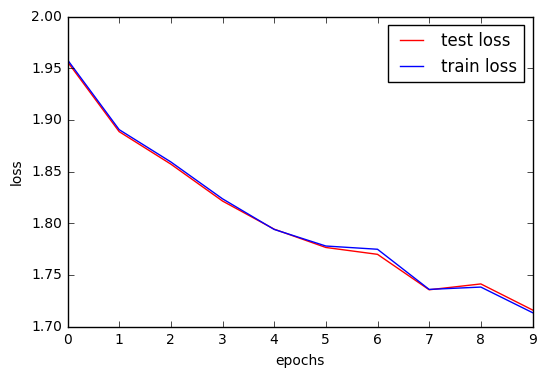

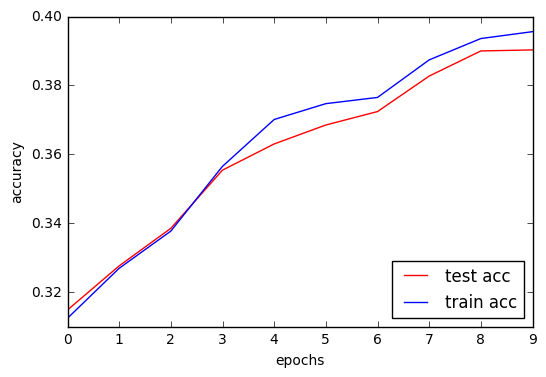

In [3]:
# for repeatability
np.random.seed(0)

# Inputs
inp = edf.Value()
lab = edf.Value()


prev_channel = 3 # RGB channel 
# evaluation bucket
bucket = 100
########################## Simple Convolution Nerual Network Model for Cifar 10 ##################################
##################################################################################################################
# please implement your main cnn model here, as described by the homework, you can mimic the previous code


f1 = edf.Param(edf.xavier((3,3, prev_channel,32)))
b1 = edf.Param(np.zeros(32))

f3 = edf.Param(edf.xavier((3,3,32,64)))
b3 = edf.Param(np.zeros(64))

f5 = edf.Param(edf.xavier((1,1,64,10)))
b5 = edf.Param(np.zeros(10))

layer1 = edf.RELU(edf.Add(Conv(f1, inp, 1, 1), b1))
layer2 = MaxPool(layer1, 4)
layer3 = edf.RELU(edf.Add(Conv(f3, layer2), b3))
layer4 = AvePool(layer3, 6)
layer5 = edf.RELU(edf.Add(Conv(f5, layer4), b5))
pred = edf.Reshape(layer5, (bucket,10))




# the standard classification layer, which you don't need to modify
pred = edf.SoftMax(pred)
loss = edf.Mean(edf.LogLoss(edf.Aref(pred,lab)))
acc = edf.Accuracy(pred,lab)


################################################################################################################## 

def eval_train():    
    
    # we only choose 1/5 of the train images for evaluation since evaluation the whole images is time consuming
    eval_imgs = t_imgs[::5]
    eval_labels = t_labels[::5]
    avg_acc = 0
    avg_loss = 0
    
    for seq in range(bucket):
        inp.set(eval_imgs[seq::bucket])
        lab.set(eval_labels[seq::bucket])
        edf.Forward()
        avg_acc += acc.value
        avg_loss += loss.value
    
    return avg_acc/bucket, avg_loss/bucket
        
def eval_test():
    
    avg_acc = 0
    avg_loss = 0
    for seq in range(bucket):
        inp.set(v_imgs[seq::bucket])
        lab.set(v_labels[seq::bucket])
        edf.Forward()
        avg_acc += acc.value
        avg_loss += loss.value
    
    return avg_acc/bucket, avg_loss/bucket

# initial accuracy 
random_acc, random_loss = eval_test()
print("Random test loss = %.4f, accuracy = %.4f" % (random_loss, random_acc))


################################################# train loop ######################################################
ep = 0
epoch = 10
batch = 100
train_loss = []; train_acc = []; test_loss =[]; test_acc = []
stime = time()
batches = range(0, len(t_labels), batch)

while ep < epoch:

    # randon shuffle the train data in each epoch
    perm = np.random.permutation(len(t_labels))

    for k in batches:
        inp.set(t_imgs[perm[k:k+batch]])
        lab.set(t_labels[perm[k:k+batch]])
        edf.Forward()
        edf.Backward(loss)
        edf.Adam()
        
    # evaluate on trainset
    t_acc, t_loss = eval_train()
    print("Epoch %d: train loss = %.4f [%.3f secs]" % (ep, t_loss,time()-stime))
    train_loss.append(t_loss)
    train_acc.append(t_acc)

    # evaluate on testset
    v_acc, v_loss = eval_test()
    print("test accuracy = %.4f" % v_acc)
    test_loss.append(v_loss)
    test_acc.append(v_acc)
    stime = time()
    ep += 1      


# plot
plt.figure(1)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(np.arange(len(test_loss)), test_loss, color='red')
plt.plot(np.arange(len(train_loss)), train_loss, color='blue')
plt.legend(['test loss', 'train loss'], loc='upper right')
plt.show()

plt.figure(2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(np.arange(len(test_acc)), test_acc, color='red')
plt.plot(np.arange(len(train_acc)), train_acc, color='blue')
plt.legend(['test acc', 'train acc'], loc='lower right')
plt.show()